In [47]:
## Version futuresales lib required = 0.1.15

!pip install -i https://test.pypi.org/simple/ futuresales_denissimo==0.1.14
# !pip install plotly==5.3.1
# !pip install neptune-client
# !pip install neptune-sklearn

Looking in indexes: https://test.pypi.org/simple/


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

import futuresales as fs

from futuresales.distribution import from_pickle, to_pickle
from futuresales.utils import make_scaled, load_credentials
from futuresales.validation import Validator, make_hpo_dataset, get_statistics

from neptune.new.types import File

/tmp/ipykernel_42024/1320099259.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook


# Base neptune configuration

In [2]:
import neptune.new as neptune

cred = load_credentials('../../credentials.json')['projects']['fs-results']

run = neptune.init(
    api_token=cred['api_token'],
    project=cred['project'],
    tags=['linear', 'baseline', 'boruta'],
)  # your credentials

Info (NVML): Driver Not Loaded. GPU usage metrics may not be reported. For more information, see https://docs-legacy.neptune.ai/logging-and-managing-experiment-results/logging-experiment-data.html#hardware-consumption 


https://app.neptune.ai/denissimo/FS-Results/e/FSRES-20
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


# Dataset preparation

In [3]:
task_df = {}

task_df['test'] = pd.read_csv('../../tmp/task_df_test.csv')
task_df['train'] = pd.read_csv('../../tmp/task_df_train.csv')
task_df['idx'] = pd.read_csv('../../tmp/idx.csv')

train = pd.read_csv('../../tmp/baseline_train_set.csv')
test = pd.read_csv('../../tmp/baseline_test_set.csv')
validation = pd.read_csv('../../tmp/baseline_validation_set.csv')

selector = from_pickle('../../tmp/feat_selector.pkl')

/home/denissimo/Repo/fs_project/env/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.0 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/denissimo/Repo/fs_project/env/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 1.0 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [4]:
train_x = train.drop(['valid_target', 'target'], axis=1)
train_y = train.loc[:, ['target']]
train_y_valid = train.loc[:, ['valid_target']]

test_x = test.drop(['valid_target', 'target'], axis=1)
test_y = test.loc[:, ['target']]
test_y_valid = test.loc[:, ['valid_target']]

validation_x = validation.drop(['valid_target', 'target'], axis=1)
validation_y = validation.loc[:, ['target']]
validation_y_valid = validation.loc[:, ['valid_target']]

train_x = make_scaled(train_x).drop('id', axis=1).reset_index().rename({'index': 'id'}, axis=1).set_index('id')
test_x = make_scaled(test_x).drop('id', axis=1).reset_index().rename({'index': 'id'}, axis=1).set_index('id')
validation_x = make_scaled(validation_x).drop('id', axis=1).reset_index().rename({'index': 'id'}, axis=1).set_index('id')

In [5]:
train_x = train_x.loc[:, selector.support_].reset_index().rename({'index': 'id'},axis=1).merge(task_df['idx'][['shop_id', 'item_id', 'id']], on='id').set_index('id')
test_x = test_x.loc[:,selector.support_].reset_index().rename({'index': 'id'},axis=1).merge(task_df['idx'][['shop_id', 'item_id', 'id']], on='id').set_index('id')
validation_x = validation_x.loc[:,selector.support_].reset_index().rename({'index': 'id'},axis=1).merge(task_df['idx'][['shop_id', 'item_id', 'id']], on='id').set_index('id')

# Model tuning

In [6]:
# define a search space
from sklearn.linear_model import Ridge, LinearRegression, Lasso, ElasticNet
import seaborn as sns
from futuresales.utils import hyperopt_objective
from hyperopt import hp
from hyperopt import fmin, tpe, Trials

searching_space = {
    'alpha': hp.loguniform('alpha', 0, 25)
}

trials = Trials()
ridge_obj = hyperopt_objective(
    Ridge,
    (train_x, train_y),
    (test_x, test_y)
)

# ridge_obj({'alpha': 1e-7})

# minimize the objective over the space
hpo = trials.fmin(ridge_obj, searching_space, algo=tpe.suggest, max_evals=100)

In [13]:
def _make_hpo_dataset(trials):
    keys = trials.results[0]['other_stuff']['kwargs'].keys()
    df = pd.DataFrame({
        'test': [el['loss'] for el in trials.results],
        'train': [el['other_stuff']['train_rmse'] for el in trials.results],
        **{key: [el['other_stuff']['kwargs'][key] for el in trials.results] for key in list(keys)}
    })

    min_hyp = df.iloc[df.test.idxmin()]
    df = df.set_index(list(keys)).stack().reset_index().rename({
        0: 'loss',
        f'level_{len(list(keys))}': 'loss_type'
    }, axis=1)
    df['loss'] = abs(df['loss'])
    return df, min_hyp

In [14]:
hpo_df, min_hyp = _make_hpo_dataset(trials)

In [15]:
hpo_df

,alpha,loss_type,loss
0,5.566299e+02,test,4.449510
1,5.566299e+02,train,0.846544
2,8.387074e+03,test,4.452287
3,8.387074e+03,train,0.847374
4,2.155288e+07,test,4.689096
...,...,...,...
195,1.666205e+04,train,0.848556
196,3.299259e+07,test,4.709743
197,3.299259e+07,train,1.385908
198,3.305811e+01,test,4.449334


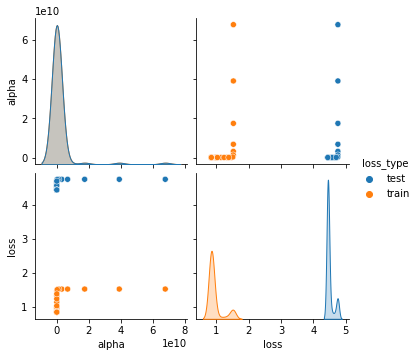

In [21]:
run['hpo'] = {
    'min_params': hpo,
    'trials': File.as_html(hpo_df),
    'trials_pkl': File.as_pickle(hpo_df),
    'cross-dependency': File.as_image(sns.pairplot(data=hpo_df, hue='loss_type').figure)
}

In [22]:
errors = {}

In [23]:
lin_validator = Validator(Ridge, **hpo)

lin_validator.fit(test_x, test_y)
errors['ridge'] = lin_validator.validate(validation_x, validation_y_valid)
residulas = get_statistics(errors['ridge'])

run['params'] = min_hyp

run['score/rmse/test'] = errors['ridge'][0]
run['score/rmse/train'] = errors['ridge'][1]
run['model'] = 'Ridge'
run['dump/residuals'].upload(File.as_pickle(residulas))
run['dump/model'].upload(File.as_pickle(lin_validator))

In [ ]:
lin_validator = Validator(Ridge, **hpo)

lin_validator.fit(test_x, test_y)

some = pd.Series(lin_validator.model.predict(validation_x).transpose(), index = validation_x.index)
some.loc[some < 0] = 0

validation_scheme = pd.DataFrame(validation_y_valid)
validation_scheme['predicted'] = some
validation_scheme.fillna(0, inplace=True)
validation_scheme.loc[:,['valid_target']]

residulas = get_statistics(
    (0, 
    0, 
    validation_scheme.predicted,
    validation_scheme.loc[:,['valid_target']]))

run['params'] = hpo

from sklearn.metrics import mean_squared_error as mse

run['score/rmse/test'] = np.sqrt(mse(validation_scheme.predicted, validation_scheme.valid_target))
run['score/rmse/train'] = np.sqrt(xgb_validator._train_err)
run['model'] = 'Ridge'
run['dump/residuals'].upload(File.as_pickle(residulas))
run['dump/model'].upload(File.as_pickle(lin_validator.model))

/home/denissimo/Repo/fs_project/env/lib/python3.8/site-packages/yellowbrick/model_selection/importances.py:194: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  warnings.warn(


Did not log prediction error chart. Error: y must be a (1,) dimensional array not (422577, 1)
Did not log cooks distance chart. Error: shapes (422577,1) and (422577,1) not aligned: 1 (dim 1) != 422577 (dim 0)


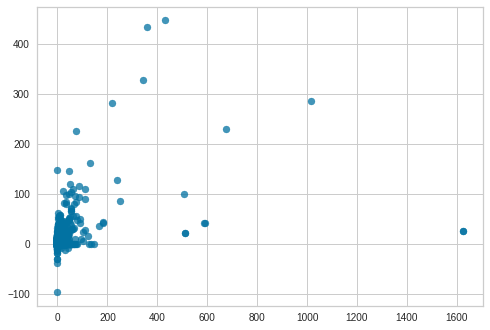

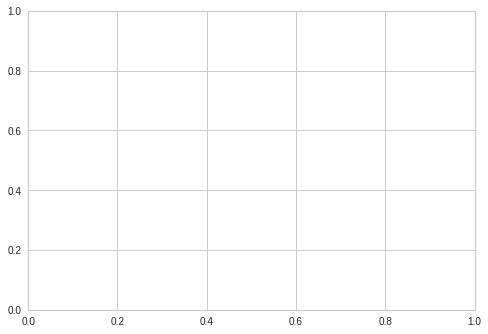

In [24]:
import neptune.new.integrations.sklearn as npt_utils

run['auto_model_summary'] = npt_utils.create_regressor_summary(
    lin_validator.model, 
    train_x, 
    test_x, 
    train_y.to_numpy(), 
    test_y_valid.to_numpy())

In [26]:
run.stop()